## Growth factors

### What are growth factors?

Growth factors attempt to measure the *growth* of a company's fundamentals. Some common growth factors, some of which are explored in this notebook, are
- `EPS` growth
- `Sales` growth
- `Forward EPS` growth
- and more...

### What's in this notebook?

Our dataset does not come with growth factors, but we can calculate some using our value factors, and then finding changes across months.

In the second section of this notebook, we consider the predictive power of growth factors.

In [2]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

# .env variables
db_url = os.getenv('DB_URL')
constituents_table = os.getenv('CONSTITUENTS_TABLE')
prices_table = os.getenv('PRICES_TABLE')

# connection to sql database
psql = create_engine(db_url)

In [5]:
# get historical monthly data

adjusted_monthly = pd.read_sql("""
    select
        *
    from
        adjusted_monthly
    """,
    psql
)

# Ensure data is sorted
adjusted_monthly = adjusted_monthly.sort_values(['ticker', 'date'])

# Compute returns per ticker
adjusted_monthly['adj_return'] = (
    adjusted_monthly.groupby('ticker')['adj_close']
    .transform(lambda x: np.log(x / x.shift(1)))
)

# Compute forward returns per ticker
adjusted_monthly['adj_return_fwd'] = (
    adjusted_monthly.groupby('ticker')['adj_return']
    .shift(-1)
)

# Drop rows with NaNs
adjusted_monthly = adjusted_monthly.dropna(subset=['adj_return', 'adj_return_fwd'])

tickers = adjusted_monthly['ticker'].unique().tolist()
sql_tickers = ", ".join(f"'{v}'" for v in tickers)

# get factor data

value_factors = pd.read_sql("select metric from factor_styles where style = 'VALUE'", psql)['metric'].to_list() + ['marketcap']
sql_value_factors = ", ".join(f"'{v}'" for v in value_factors)

value_factor_data = pd.read_sql(
    f"""
    select
        *
    from
        fundamentals_monthly
    where
        ticker in ({sql_tickers})
    and
        metric in ({sql_value_factors})    
    """,
    psql
)

# get constituents meta-data

constituents = pd.read_sql(
    """
    select
        ticker, start_date, end_date, sector
    from
        constituents
    """,
    psql
).dropna(subset=['sector'])

constituents['start_date'] = pd.to_datetime(constituents['start_date'])

# keep the row with the latest start_date for each ticker
constituents_latest = (
    constituents
    .sort_values(['ticker', 'start_date'], ascending=[True, False])
    .drop_duplicates(subset='ticker', keep='first')
    .reset_index(drop=True)
)

constituents_latest = constituents[['ticker', 'sector']]

### Filling sales growth

We have $\text{Prices}/\text{Sales}$, so we can calculate $\text{Sales}$ by
$$ \text{Sales} = \frac{\text{Market cap}}{\text{Price}/\text{Sales}}$$

In [6]:
sales = value_factor_data[value_factor_data['metric'] == 'price_sales'].copy()
sales = sales.rename(columns = {'value': 'price_sales'})[['date', 'ticker', 'price_sales']]
marketcap = value_factor_data[value_factor_data['metric'] == 'marketcap'].copy()
marketcap = marketcap.rename(columns = {'value': 'marketcap'})[['date', 'ticker', 'marketcap']]

In [7]:
sales_and_marketcap = sales.merge(marketcap, how='left', on = ['ticker', 'date'])

In [10]:
sales_and_marketcap['sales'] = sales_and_marketcap['marketcap'] / sales_and_marketcap['price_sales']

In [9]:
sales_and_marketcap['sales_m1m'] = (
    sales_and_marketcap
    .groupby('ticker', group_keys = False)['sales']
    .apply(lambda x: np.log(x / x.shift(1)))
)

sales_m1m = (
    sales_and_marketcap[['date', 'ticker', 'sales_m1m']]
    .replace([np.inf, -np.inf], np.nan)   # turn inf into NaN
    .dropna()
)
sales_m1m = sales_m1m.rename(columns = {'sales_m1m': 'value'})
sales_m1m['metric'] = 'sales_mtm'
sales_m1m.to_sql('fundamentals_monthly', psql, if_exists='append', index=False)

/Users/haekim/miniconda3/envs/research/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/haekim/miniconda3/envs/research/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)

In [17]:
sales_factor = pd.DataFrame([{
    'metric': 'sales_mtm',
    'style': 'GROWTH'
}])
sales_factor.to_sql('factor_styles', psql, if_exists='append', index=False)

1

### Filling EPS growth

We can calculate EPS growth by calculating earnings from
$$ \text{Earnings} = \frac{\text{Market cap}}{\text{P/E}}$$

and shares outstanding from

$$ \text{Shares outstanding} = \frac{\text{Market cap}}{\text{Share price}}$$

and finally EPS

$$ \text{EPS} = \frac{\text{Earnings}}{\text{Shares outstanding}}$$

In [12]:
pe = value_factor_data[value_factor_data['metric'] == 'price_earnings']
pe = pe.rename(columns = {'value': 'pe'})[['date', 'ticker', 'pe']]

pe_mc = pe.merge(marketcap, how = 'left', on = ['date', 'ticker'])
pe_mc_prc = pe_mc.merge(adjusted_monthly, how = 'left', on = ['date', 'ticker']).dropna()

pe_mc_prc['marketcap'] *= 1e6 # marketcap is originally in million

In [13]:
pe_mc_prc['shares_outstanding'] = pe_mc_prc['marketcap'] / pe_mc_prc['adj_close']
pe_mc_prc['date'] = pd.to_datetime(pe_mc_prc['date'])
aapl = pe_mc_prc[pe_mc_prc['ticker'] == 'AAPL']

Quick sense check with `AAPL` - I know that `AAPL` has been buying back for the past few years.

Text(0.5, 1.0, 'AAPL Shares outstanding')

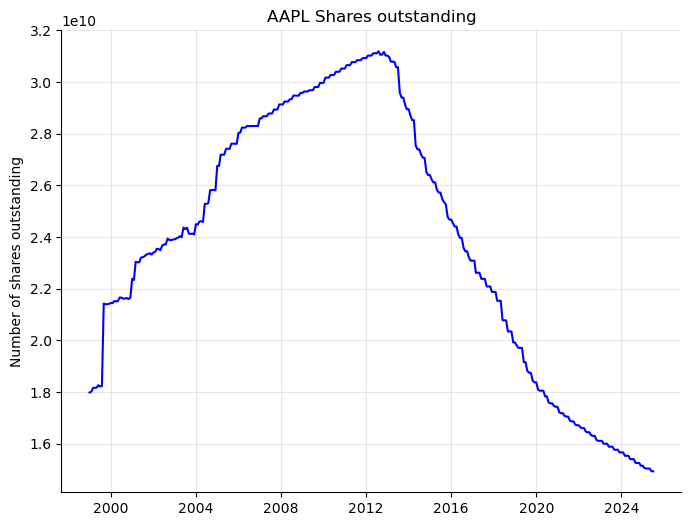

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(aapl['date'], aapl['shares_outstanding'], color='blue')
sns.despine()
plt.grid(alpha = 0.3)
plt.ylabel('Number of shares outstanding')
plt.title('AAPL Shares outstanding')

We see this... so this gives me more confidence.

In [15]:
pe_mc_prc['earnings'] = pe_mc_prc['marketcap'] / pe_mc_prc['pe']
pe_mc_prc['eps'] = pe_mc_prc['earnings'] / pe_mc_prc['shares_outstanding']
aapl = pe_mc_prc[pe_mc_prc['ticker'] == 'AAPL']

Text(0.5, 1.0, 'AAPL Historical Raw EPS')

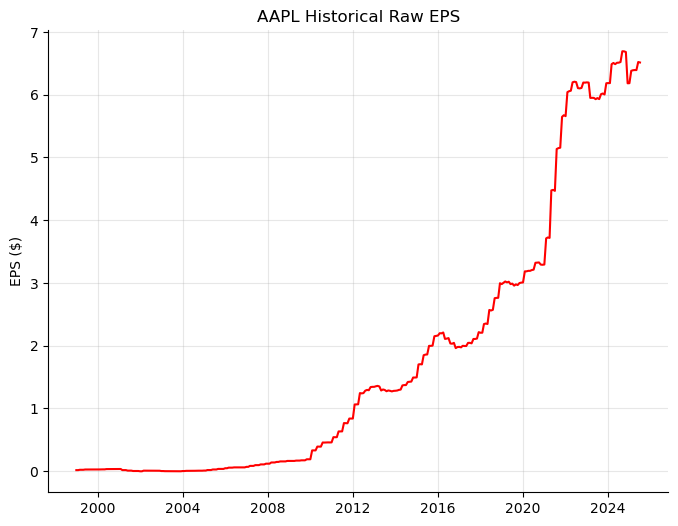

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(aapl['date'], aapl['eps'], color = 'red')
plt.grid(alpha=0.3)
sns.despine()
plt.ylabel('EPS ($)')
plt.title('AAPL Historical Raw EPS')

Checking with sources online, this seems inline.

In [15]:
pe_mc_prc['eps_mtm'] = (
    pe_mc_prc
    .groupby('ticker', group_keys = False)['eps']
    .apply(lambda x: np.log(x / x.shift(1)))
).dropna()

eps = (
    pe_mc_prc[['date', 'ticker', 'eps_mtm']]
    .replace([np.inf, -np.inf], np.nan)   # turn inf into NaN
    .dropna()
    .rename(columns = {'eps_mtm': 'value'})
)
eps['metric'] = 'eps_mtm'

/Users/haekim/miniconda3/envs/research/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/haekim/miniconda3/envs/research/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
eps.to_sql('fundamentals_monthly', psql, if_exists='append', index=False)

831

In [ ]:
eps_factor = pd.DataFrame([{
    'metric': 'eps_mtm',
    'style': 'GROWTH'
}])

eps_factor.to_sql('factor_styles', psql, if_exists='append', index=False)

## Analysis of growth factors

We now consider the performance of sector-neutralised growth factors for both `EPS Growth` and `Sales growth`.

In [18]:
from scipy.stats import zscore

growth_factors = pd.read_sql("""
    select 
        * 
    from 
        fundamentals_monthly
    where 
        metric 
    in 
        ('eps_mtm', 'sales_mtm')
""", psql)

prc_and_growth = adjusted_monthly.merge(growth_factors, how = 'left', on = ['date', 'ticker'])
prc_and_growth = prc_and_growth.merge(constituents_latest, on='ticker').dropna()

In [19]:
prc_and_growth

,date,adj_close,volume,ticker,adj_return,adj_return_fwd,metric,value,sector
0,2000-07-31,24.4499,8053179.0,A,-0.593227,0.403419,sales_mtm,0.00461,Healthcare
1,2000-08-31,36.5999,3479902.0,A,0.403419,-0.220331,sales_mtm,-0.00205,Healthcare
2,2000-08-31,36.5999,3479902.0,A,0.403419,-0.220331,eps_mtm,-0.00019,Healthcare
3,2000-09-30,29.3624,3677439.0,A,-0.220331,-0.055132,sales_mtm,0.14237,Healthcare
4,2000-09-30,29.3624,3677439.0,A,-0.220331,-0.055132,eps_mtm,0.15318,Healthcare
...,...,...,...,...,...,...,...,...,...
242486,2025-04-30,155.8788,2926200.0,ZTS,-0.048036,0.075290,eps_mtm,0.00379,Healthcare
242487,2025-05-31,168.0680,5467800.0,ZTS,0.075290,-0.078171,sales_mtm,0.00579,Healthcare
242488,2025-05-31,168.0680,5467800.0,ZTS,0.075290,-0.078171,eps_mtm,0.02010,Healthcare
242489,2025-06-30,155.4303,2826600.0,ZTS,-0.078171,-0.044939,sales_mtm,-0.00121,Healthcare


In [20]:
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

prc_and_growth = prc_and_growth.sort_values(['date','sector'])

# Winsorize + z-score sector-neutralised
def winsorize_and_zscore(x):
    if x.notna().sum() > 1:
        # winsorize expects array, clip 1% tails
        x_w = winsorize(x, limits=(0.01, 0.01))
        return zscore(x_w, ddof=1)
    else:
        return 0

prc_and_growth['value_score'] = (
    prc_and_growth
    .groupby(['date','metric','sector'])['value']
    .transform(winsorize_and_zscore)
)

# Now compute IC
growth_ic = []
for date, data in prc_and_growth.groupby('date'):
    for factor, fdata in data.groupby('metric'):
        ic_val = fdata[['value_score','adj_return_fwd']].corr(
            method='spearman'
        ).iloc[0,1]
        growth_ic.append({'date': date, 'factor': factor, 'ic': ic_val})

growth_ic_df = pd.DataFrame(growth_ic)

Text(0.5, 1.0, 'Growth factors show moderate predictability, with waning strength post-2020')

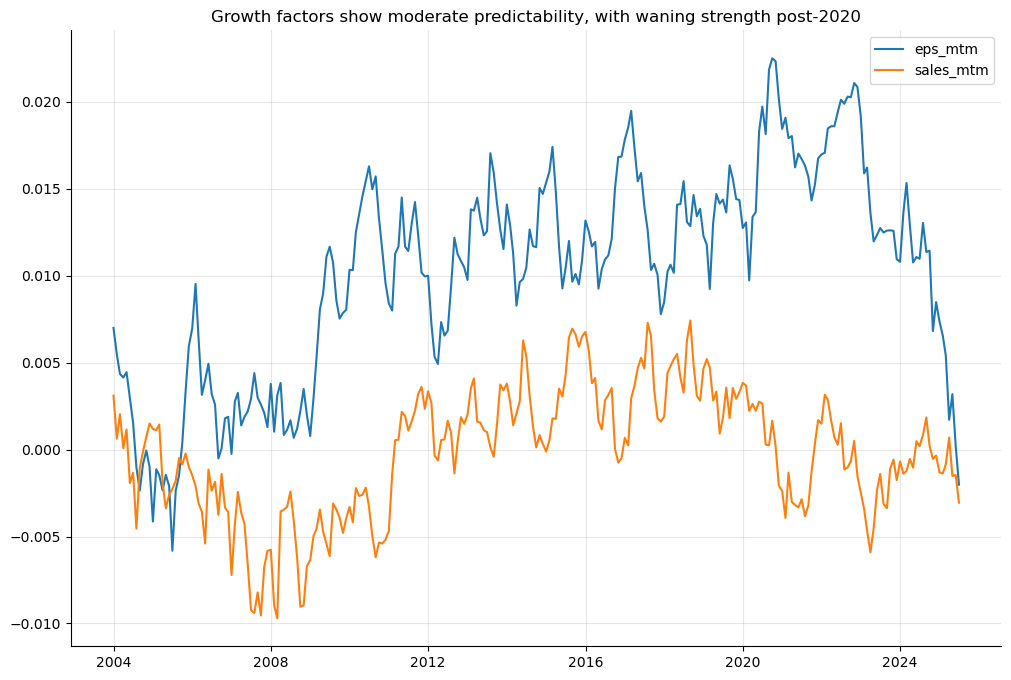

In [21]:
growth_ic_df['rolling_ic'] = (
    growth_ic_df
    .groupby('factor')['ic']
    .rolling(window=12*5)
    .mean()
    .reset_index(level=0, drop=True)
)

plt.figure(figsize=(12, 8))
for factor, data in growth_ic_df.groupby('factor'):
    plt.plot(data['date'], data['rolling_ic'], label=factor)
plt.grid(alpha=0.3)
sns.despine()
plt.legend()
plt.title('Growth factors show moderate predictability, with waning strength post-2020')

### Composite growth factor

In [22]:
composite_growth = []

for date, data in growth_factors.groupby('date'):
    for ticker, tdata in data.groupby('ticker'):
        composite_growth.append({
            'date': date,
            'ticker': ticker,
            'score': np.mean(tdata['value'])
        })

In [23]:
composite_growth_df = pd.DataFrame(composite_growth)

In [24]:
return_and_comp = adjusted_monthly.merge(composite_growth_df, how = 'left', on = ['date', 'ticker'])

In [25]:
comp_ic = []
for date, data in return_and_comp.groupby('date'):
    comp_ic.append({
        'date': date,
        'ic': data['score'].corr(data['adj_return_fwd'], method = 'spearman')
    })

comp_ic_df = pd.DataFrame(comp_ic).dropna()

Text(0.5, 1.0, 'Growth is a fairly consistent, weak indicator of forward returns since 200, but with decreasing strength from 2018')

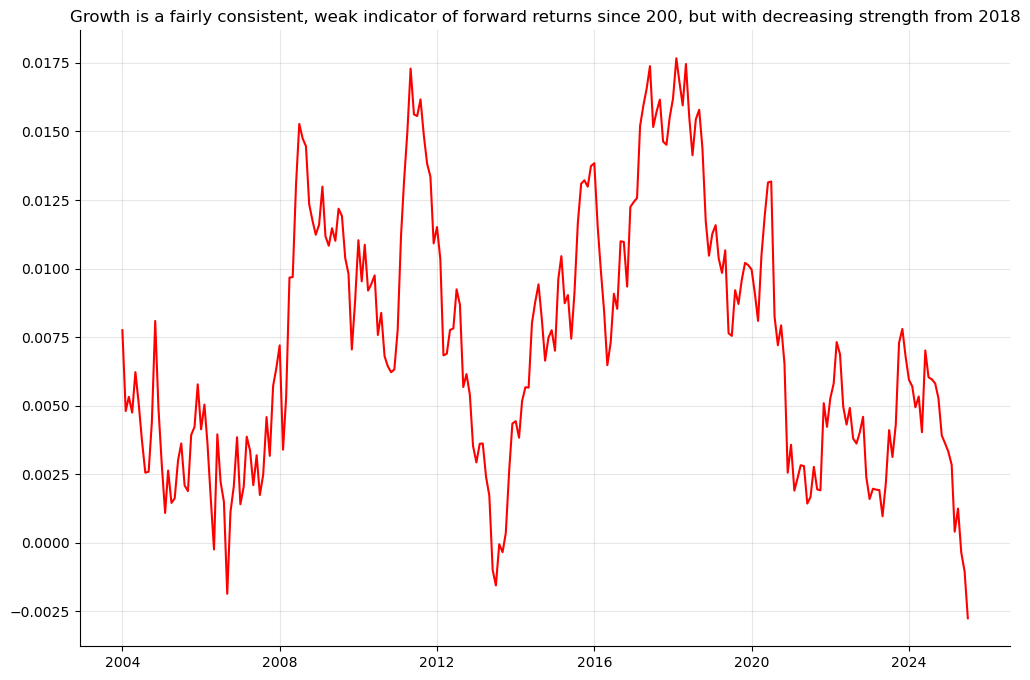

In [26]:
comp_ic_df['rolling_ic'] = comp_ic_df['ic'].rolling(window=12 * 5).mean()
comp_ic_df = comp_ic_df.dropna()

plt.figure(figsize=(12, 8))
plt.plot(comp_ic_df['date'], comp_ic_df['rolling_ic'], color='red')
sns.despine()
plt.grid(alpha=0.3)
plt.title('Growth is a fairly consistent, weak indicator of forward returns since 200, but with decreasing strength from 2018')

In [ ]:
# save to composite database

composite_growth_df['score'] = composite_growth_df.groupby('date')['score'].transform(lambda x: zscore(x))
composite_growth_df['style'] = 'GROWTH'
composite_growth_df.to_sql('factor_composites', psql, if_exists='append', index=False)